# Chose 3 different classification techniques

## Read data
Only `learn` file relevant for training:
`data/breast_cancer/breast-cancer-diagnostic.shuf.lrn.csv`
Only `test` file relevant for testing:
`data/breast_cancer/breast-cancer-diagnostic.shuf.test.csv`

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
breast_cancer = pd.read_csv('data/breast_cancer/breast-cancer-diagnostic.shuf.lrn.csv')
breast_cancer_full_test = pd.read_csv('data/breast_cancer/breast-cancer-diagnostic.shuf.tes.csv')

### Check data
`info()` method shows if there are missing values
it shows that there aren't any missing values (non-null for every feature)

In [3]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 32 columns):
ID                         285 non-null int64
class                      285 non-null object
radiusMean                 285 non-null float64
 textureMean               285 non-null float64
 perimeterMean             285 non-null float64
 areaMean                  285 non-null float64
 smoothnessMean            285 non-null float64
 compactnessMean           285 non-null float64
 concavityMean             285 non-null float64
 concavePointsMean         285 non-null float64
 symmetryMean              285 non-null float64
 fractalDimensionMean      285 non-null float64
 radiusStdErr              285 non-null float64
 textureStdErr             285 non-null float64
 perimeterStdErr           285 non-null float64
 areaStdErr                285 non-null float64
 smoothnessStdErr          285 non-null float64
 compactnessStdErr         285 non-null float64
 concavityStdErr           285 non

In [4]:
print(breast_cancer['class'].unique())


['B' 'M']


## Correlation map

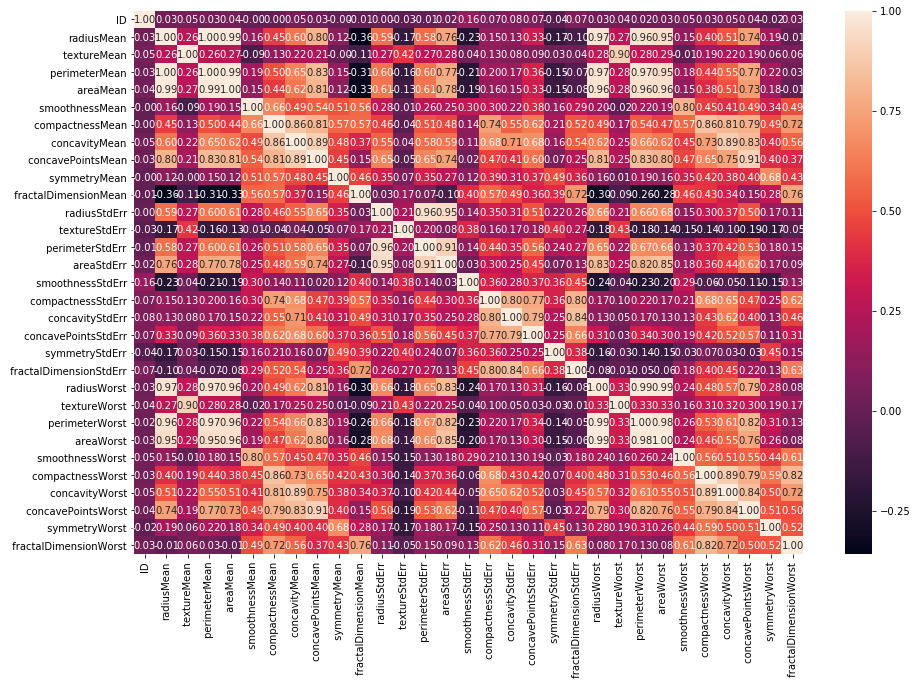

In [5]:
plt.figure(figsize=(15,10))
sns.heatmap(breast_cancer.corr(),annot=True,fmt='.2f')
plt.show()

## Creating train and test data 
Using a stratified approach to ensure all the classes are in the training data.

In [16]:
X = breast_cancer.drop(['ID','class'], axis = 1).values
y = breast_cancer['class'].values
X_full_test = breast_cancer_full_test.drop(['ID'], axis=1).values

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)


In [18]:
from sklearn.pipeline import Pipeline

# Select Features using RFECV
class PipelineRFE(Pipeline):
    # Source: https://ramhiser.com/post/2018-03-25-feature-selection-with-scikit-learn-pipeline/
    def fit(self, X, y=None, **fit_params):
        super(PipelineRFE, self).fit(X, y, **fit_params)
        self.feature_importances_ = self.steps[-1][-1].feature_importances_
        return self

## Starting with a simple model to:
+ get a sense of how challenging the problem is
+ many more things might go wrong with complex models
+ how much signal can we pull out using basic models

## Logistic Regression
__Score history:__  

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.34 | 0.17, 0.50, 0.25 | 0.11, 0.34, 0.17 |
| with robustScaler | 0.98 | 0.97, 0.98, 0.97 | 0.98, 0.98, 0.98 |
| - | - | - | - |


### Logistic Regression parameters
TODO

In [19]:
from sklearn.linear_model.logistic import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, confusion_matrix  

In [84]:
pipe_logreg = Pipeline([
    ('scaler', RobustScaler()),
    ('logreg', LogisticRegression())
])

In [85]:
# create parameter list for ridge regression
params_logreg = {
    'logreg__C':[0.5, 0.6, 0.7, 1.1],
    'logreg__class_weight': ['balanced']
}

In [86]:
# setup cross validation parameter grid search
grid_logreg = GridSearchCV(estimator=pipe_logreg,
    param_grid=params_logreg,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1)

In [87]:
# fitting model on training data
grid_logreg.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.5s finished
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_rati

In [88]:
# extracting best parameters (can be used for finer hyper parameter tuning)
grid_logreg.best_params_

{'logreg__C': 0.5, 'logreg__class_weight': 'balanced'}

In [89]:
grid_logreg.score(X_test, y_test) 


0.9769241417497232

In [90]:
y_pred = grid_logreg.predict(X_test)

In [91]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           B       1.00      0.96      0.98        57
           M       0.94      1.00      0.97        29

    accuracy                           0.98        86
   macro avg       0.97      0.98      0.97        86
weighted avg       0.98      0.98      0.98        86



In [92]:
print(confusion_matrix(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

[[55  2]
 [ 0 29]]


## KNN-Classifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 0.83 | 0.82, 0.78, 0.79 | 0.82, 0.83, 0.82 |
| with MinMaxScaler | 0.98 | 0.98, 0.97, 0.97 | 0.98, 0.98, 0.98 |
| - | - | - | - |

### KNN Parameters:

In [200]:
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.preprocessing import MinMaxScaler


In [201]:
pipe_knn = Pipeline([
    ('scaler', MinMaxScaler()),
    ('knn', KNeighborsClassifier())
])

In [205]:
params_knn = {
    'knn__n_neighbors': [x for x in range(1,50,2)], 
    'knn__p': [1, 2],
    'knn__weights': ['uniform', 'distance']
}


In [213]:
grid_knn = GridSearchCV(estimator=pipe_knn,
    param_grid=params_knn,
    cv=3,
    #scoring='f1_weighted',
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)

In [214]:
grid_knn.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    4.7s finished
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        MinMaxScaler(copy=True,
                                                     feature_range=(0, 1))),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'k

In [215]:
grid_knn.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}

In [216]:
grid_knn.score(X_test, y_test) 

0.9767441860465116

In [217]:
y_pred_knn = grid_knn.predict(X_test)

In [218]:
print(classification_report(y_test, y_pred_knn)) 

              precision    recall  f1-score   support

           B       0.97      1.00      0.98        57
           M       1.00      0.93      0.96        29

    accuracy                           0.98        86
   macro avg       0.98      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86



In [219]:
print(confusion_matrix(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)

[[57  0]
 [ 2 27]]


### train on full learn dataset and save output

In [220]:
grid_knn.fit(X, y)
y_full_pred_knn = grid_knn.predict(X_full_test)
test_out_knn = pd.DataFrame()
test_out_knn['ID'] = breast_cancer_full_test['ID']
test_out_knn['class'] = y_full_pred_knn
test_out_knn.to_csv('breast_cancer_test_knn.csv', index=False)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    5.2s finished


In [221]:
grid_knn.best_estimator_

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('knn',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=9, p=1,
                                      weights='uniform'))],
         verbose=False)

## Random Forest
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 1.00 | 1.00, 1.00, 1.00 | 1.00, 1.00, 1.00 |
| - | - | - | - |

### Random Forest parameters
- __n_estimators:__
    - number of trees in the forest
- __max_depth:__
    - maximum depth of the tree
- __min_samples_split:__
    - the min. number of samples required to split an internal node
- __min_samples_leaf:__
    - the minimum number of samples required to be at a leaf node
- __min_weight_fraction_leaf:__
    - the minimum weighted fraction of the sum total of weights
- __max_features:__
    - the number of features to consider when looking for the best split
- __min_impurity_decrease:__
    - A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

In [21]:
pipe_rf = PipelineRFE([
    ('rf', RandomForestClassifier())
])

In [22]:
params_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 5, 7, 9, 10, 11, 13, 15, 20],
    'rf__min_samples_split': [2, 3, 4, 5, 6],
    'rf__max_leaf_nodes': [None, 5, 6, 7, 8, 9],
    'rf__class_weight': [None, 'balanced']
}


In [23]:
grid_rf = GridSearchCV(estimator=pipe_rf,
    param_grid=params_rf,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1)


In [24]:
grid_rf.fit(X_train, y_train)


Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   35.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  4.5min finished
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=PipelineRFE(memory=None,
                                   steps=[('rf',
                                           RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
                                                                  min_samples_leaf=1,
                                                                  min_samp

In [25]:
grid_rf.best_params_

{'rf__class_weight': 'balanced',
 'rf__max_depth': None,
 'rf__max_leaf_nodes': 7,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 50}

In [26]:
grid_rf.score(X_test, y_test)

1.0

In [27]:
y_pred_rf = grid_rf.predict(X_test)

In [28]:
print(classification_report(y_test, y_pred_rf)) 

              precision    recall  f1-score   support

           B       1.00      1.00      1.00        57
           M       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



In [29]:
print(confusion_matrix(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)

[[57  0]
 [ 0 29]]


### train on full learn dataset and save output

In [232]:
grid_rf.fit(X, y)
y_full_pred_rf = grid_rf.predict(X_full_test)
test_out_rf = pd.DataFrame()
test_out_rf['ID'] = breast_cancer_full_test['ID']
test_out_rf['class'] = y_full_pred_rf
test_out_rf.to_csv('breast_cancer_test_rf.csv', index=False)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  4.6min finished


In [30]:
grid_rf.best_estimator_


PipelineRFE(memory=None,
            steps=[('rf',
                    RandomForestClassifier(bootstrap=True,
                                           class_weight='balanced',
                                           criterion='gini', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=7,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=4,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=50, n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False))],
            verbose=False)

In [31]:
pipe_rf.set_params(**grid_rf.best_params_)
rfecv_rf = RFECV(estimator=pipe_rf, cv=3, scoring="accuracy")

In [32]:
rfecv_rf.fit(X_train, y_train)


RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('rf',
                                    RandomForestClassifier(bootstrap=True,
                                                           class_weight='balanced',
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=7,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=4,
                                                           min_weight_fraction_leaf=0.0,
                   

Optimal number of features : 30
Optimal features: 
 Index(['ID', 'class', 'radiusMean', ' textureMean', ' perimeterMean',
       ' areaMean', ' smoothnessMean', ' compactnessMean', ' concavityMean',
       ' concavePointsMean', ' symmetryMean', ' fractalDimensionMean',
       ' radiusStdErr', ' textureStdErr', ' perimeterStdErr', ' areaStdErr',
       ' smoothnessStdErr', ' compactnessStdErr', ' concavityStdErr',
       ' concavePointsStdErr', ' symmetryStdErr', ' fractalDimensionStdErr',
       ' radiusWorst', ' textureWorst', ' perimeterWorst', ' areaWorst',
       ' smoothnessWorst', ' compactnessWorst', ' concavityWorst',
       ' concavePointsWorst'],
      dtype='object')


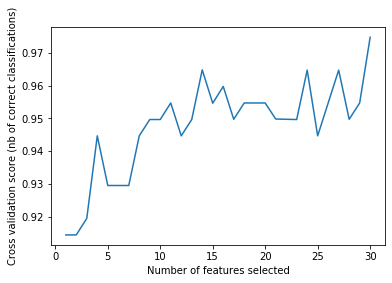

In [33]:
print("Optimal number of features : %d" % rfecv_rf.n_features_)
print("Optimal features: \n", breast_cancer.columns[rfecv_rf.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), rfecv_rf.grid_scores_)
plt.show()

In [34]:
X_train_dropped_rf = X_train[:,rfecv_rf.get_support(indices=True)]
X_test_dropped_rf = X_test[:,rfecv_rf.get_support(indices=True)]
rfecv_rf.fit(X_train_dropped_rf, y_train)
y_pred_dropped_rf = rfecv_rf.predict(X_test_dropped_rf)

In [35]:
print(y_pred_dropped_rf.shape)
print(classification_report(y_test, y_pred_dropped_rf)) 

(86,)
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        57
           M       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



## Creating a GradientBoostingClassifier
__Score history:__

|description | accuracy | marco avg | weighted avg |
|------------| -------- | --------- | ------------ |
| first try | 1.00 | 1.00, 1.00, 1.00 | 1.00, 1.00, 1.00 |
| - | - | - | - |

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV

In [39]:
pipe_gbc = PipelineRFE([
    ('gbc', GradientBoostingClassifier())
])

In [40]:
params_gbc = {
    'gbc__n_estimators': [100, 200],
    'gbc__max_depth': [4, 5, 6, 7, 9],
    'gbc__max_features': ['log2'],
    'gbc__learning_rate': [0.05, 0.1, 0.15, 0.3],
    'gbc__subsample': [0.8]
}

In [41]:
grid_gbc = GridSearchCV(estimator=pipe_gbc,
    param_grid=params_gbc,
    cv=3,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)


In [42]:
grid_gbc.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=PipelineRFE(memory=None,
                                   steps=[('gbc',
                                           GradientBoostingClassifier(criterion='friedman_mse',
                                                                      init=None,
                                                                      learning_rate=0.1,
                                                                      loss='deviance',
                                                                      max_depth=3,
                                                                      max_features=None,
                                                                      max_leaf_nodes=None,
                                                                      min_impurity_decrease=0.0,
                                                                      min_impurity_split=None,
                                          

In [43]:
grid_gbc.best_params_

{'gbc__learning_rate': 0.3,
 'gbc__max_depth': 4,
 'gbc__max_features': 'log2',
 'gbc__n_estimators': 200,
 'gbc__subsample': 0.8}

In [44]:
grid_gbc.score(X_test, y_test)

0.9883206499565395

In [45]:
y_pred_gbc = grid_gbc.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred_gbc)) 

              precision    recall  f1-score   support

           B       0.98      1.00      0.99        57
           M       1.00      0.97      0.98        29

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



In [47]:
print(confusion_matrix(y_test, y_pred_gbc))
cm = confusion_matrix(y_test, y_pred_gbc)

[[57  0]
 [ 1 28]]


### train on full learn dataset and save output

In [187]:
grid_gbc.fit(X, y)
y_full_pred_gbc = grid_gbc.predict(X_full_test)
test_out_gbc = pd.DataFrame()
test_out_gbc['ID'] = breast_cancer_full_test['ID']
test_out_gbc['class'] = y_full_pred_gbc
test_out_gbc.to_csv('breast_cancer_test_gbc.csv', index=False)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.7s finished


In [188]:
grid_gbc.best_estimator_

Pipeline(memory=None,
         steps=[('gbc',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=5, max_features='log2',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=200,
                                            n_iter_no_change=None,
                                            presort='auto', random_state=None,
                                            subsample=0.8, tol=0.0001,
                            

In [48]:
pipe_gbc.set_params(**grid_gbc.best_params_)
rfecv_gbc = RFECV(estimator=pipe_gbc, cv=3, scoring="accuracy")

In [49]:
rfecv_gbc.fit(X_train, y_train)

RFECV(cv=3,
      estimator=PipelineRFE(memory=None,
                            steps=[('gbc',
                                    GradientBoostingClassifier(criterion='friedman_mse',
                                                               init=None,
                                                               learning_rate=0.3,
                                                               loss='deviance',
                                                               max_depth=4,
                                                               max_features='log2',
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                                                               min_impurity_split=None,
                                                               min_samples_leaf=1,
                                                               min_samples

Optimal number of features : 15
Optimal features: 
 Index(['radiusMean', ' textureMean', ' areaMean', ' smoothnessMean',
       ' compactnessMean', ' radiusStdErr', ' concavePointsStdErr',
       ' symmetryStdErr', ' radiusWorst', ' textureWorst', ' perimeterWorst',
       ' smoothnessWorst', ' compactnessWorst', ' concavityWorst',
       ' concavePointsWorst'],
      dtype='object')


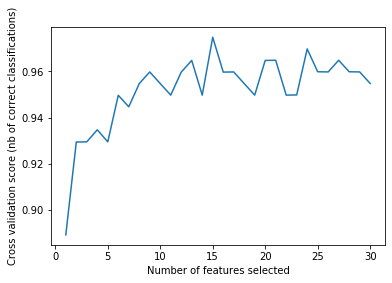

In [51]:
print("Optimal number of features : %d" % rfecv_gbc.n_features_)
print("Optimal features: \n", breast_cancer.columns[rfecv_gbc.get_support(indices=True)])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv_gbc.grid_scores_) + 1), rfecv_gbc.grid_scores_)
plt.show()

In [52]:
X_train_dropped_gbc = X_train[:,rfecv_gbc.get_support(indices=True)]
X_test_dropped_gbc = X_test[:,rfecv_gbc.get_support(indices=True)]
rfecv_gbc.fit(X_train_dropped_gbc, y_train)
y_pred_dropped_gbc = rfecv_gbc.predict(X_test_dropped_gbc)

In [53]:
print(y_pred_dropped_gbc.shape)
print(classification_report(y_test, y_pred_dropped_gbc)) 

(86,)
              precision    recall  f1-score   support

           B       1.00      1.00      1.00        57
           M       1.00      1.00      1.00        29

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86



## Creating MLP-Classifier



In [126]:
from sklearn.neural_network import MLPClassifier

In [173]:
mdl_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', alpha=0.0001, 
						batch_size=400, learning_rate='constant', learning_rate_init=0.001, 
                        max_iter=300, tol=1e-6, verbose=True)


In [174]:
mdl_mlp.fit(X_train, y_train)

c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:350: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = inf
Iteration 21, loss = inf
Iteration 22, loss = inf
Iteration 23, loss = inf
Iteration 24, loss = inf
Iteration 25, loss = inf
Iteration 26, loss = inf
Iteration 27, loss = inf
Iteration 28, loss = inf
Iteration 29, loss = inf
Iteration 30, loss = inf
Iteration 31, loss = inf
Iteration 32, loss = inf
Iteration 33, loss = inf
Iteration 34, loss = inf
Iteration 35, loss = inf
Iteration 36, loss = inf
Iteration 37, loss = inf
Iteration 38, loss = inf
Iteration 39, loss = inf
Iteration 40, loss = inf
Iteration

MLPClassifier(activation='relu', alpha=0.0001, batch_size=400, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=1e-06,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [175]:
mdl_mlp.score(X_test, y_test)

0.6627906976744186

In [176]:
y_pred_mdl = mdl_mlp.predict(X_test)

In [177]:
print(classification_report(y_test, y_pred_mdl)) 

              precision    recall  f1-score   support

           B       0.66      1.00      0.80        57
           M       0.00      0.00      0.00        29

    accuracy                           0.66        86
   macro avg       0.33      0.50      0.40        86
weighted avg       0.44      0.66      0.53        86



c:\users\redbull129\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [168]:
print(confusion_matrix(y_test, y_pred_mdl))
cm = confusion_matrix(y_test, y_pred_mdl)



[[ 0 57]
 [ 0 29]]
